**Wuhan Coronavirus 2019-nCoV**

Thanks to Brenda So and John Hopkins University for providing this data set.

The interactive map from https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6 
was the insperation for creating this kernal, and the referenced data sources have been very helpful for my friends and myself and my friends to get acurate information as the outbreak progresses. 

Next step is to try to overlay the simple SEIR model over the actual data. https://www.r-bloggers.com/sir-model-with-desolve-ggplot2/  was used generate the inital model



In [1]:
# Load packages

library(data.table)
library(ggplot2)
library(lubridate)
library(leaflet)
library(dplyr)
library(tidyverse)
library(deSolve)
library(htmltools)
library(leaflet.extras)
library(mapview)
library(htmlwidgets)
library(IRdisplay)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:base’:

    date



Attaching package: ‘dplyr’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.3     ✔ purrr   0.3.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ dplyr::between()         masks data.table::betw

In [2]:
# Load the data
dat <- fread('../input/2019-coronavirus-dataset-01212020-01262020/2019_nCoV_20200121_20200206.csv')

In [3]:
# Quick look at the data 
str(dat)

Classes ‘data.table’ and 'data.frame':	1877 obs. of  7 variables:
 $ Province/State: chr  "Hubei" "Guangdong" "Zhejiang" "Henan" ...
 $ Country/Region: chr  "Mainland China" "Mainland China" "Mainland China" "Mainland China" ...
 $ Last Update   : chr  "2/5/20 16:43" "2/5/20 13:23" "2/5/20 15:13" "2/5/20 15:03" ...
 $ Confirmed     : int  16678 895 895 764 661 548 530 376 341 307 ...
 $ Suspected     : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Recovered     : int  538 49 78 47 54 27 23 15 23 15 ...
 $ Death         : int  479 0 0 2 0 0 0 2 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [4]:
# set NA to 0
dat[is.na(dat)] <- 0

# delete the duplicated entrys by date and time of entry. 

dat =
dat %>% 
  mutate(`Last Update` = parse_date_time(`Last Update`,c("mdy_HM","mdy"))) %>%
  group_by(`Province/State`,`Country/Region`,`Last Update`) %>% 
  filter(Confirmed == max(Confirmed)) %>% 
  distinct

Warning message:
“ 134 failed to parse.”


In [5]:
dat %>%
   filter(`Country/Region`== 'South Korea')

Province/State,Country/Region,Last Update,Confirmed,Suspected,Recovered,Death
<chr>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
,South Korea,2020-02-05 15:33:00,19,0,0,0
,South Korea,2020-02-04 15:33:00,16,0,0,0
,South Korea,2020-02-02 02:23:00,15,0,0,0
,South Korea,NA,15,0,0,0
,South Korea,2020-02-01 10:43:00,12,0,0,0
,South Korea,2020-02-01 10:00:00,12,0,0,0
,South Korea,2020-01-31 14:00:00,11,0,0,0
,South Korea,2020-01-30 21:30:00,6,0,0,0
,South Korea,2020-01-30 11:00:00,4,0,0,0


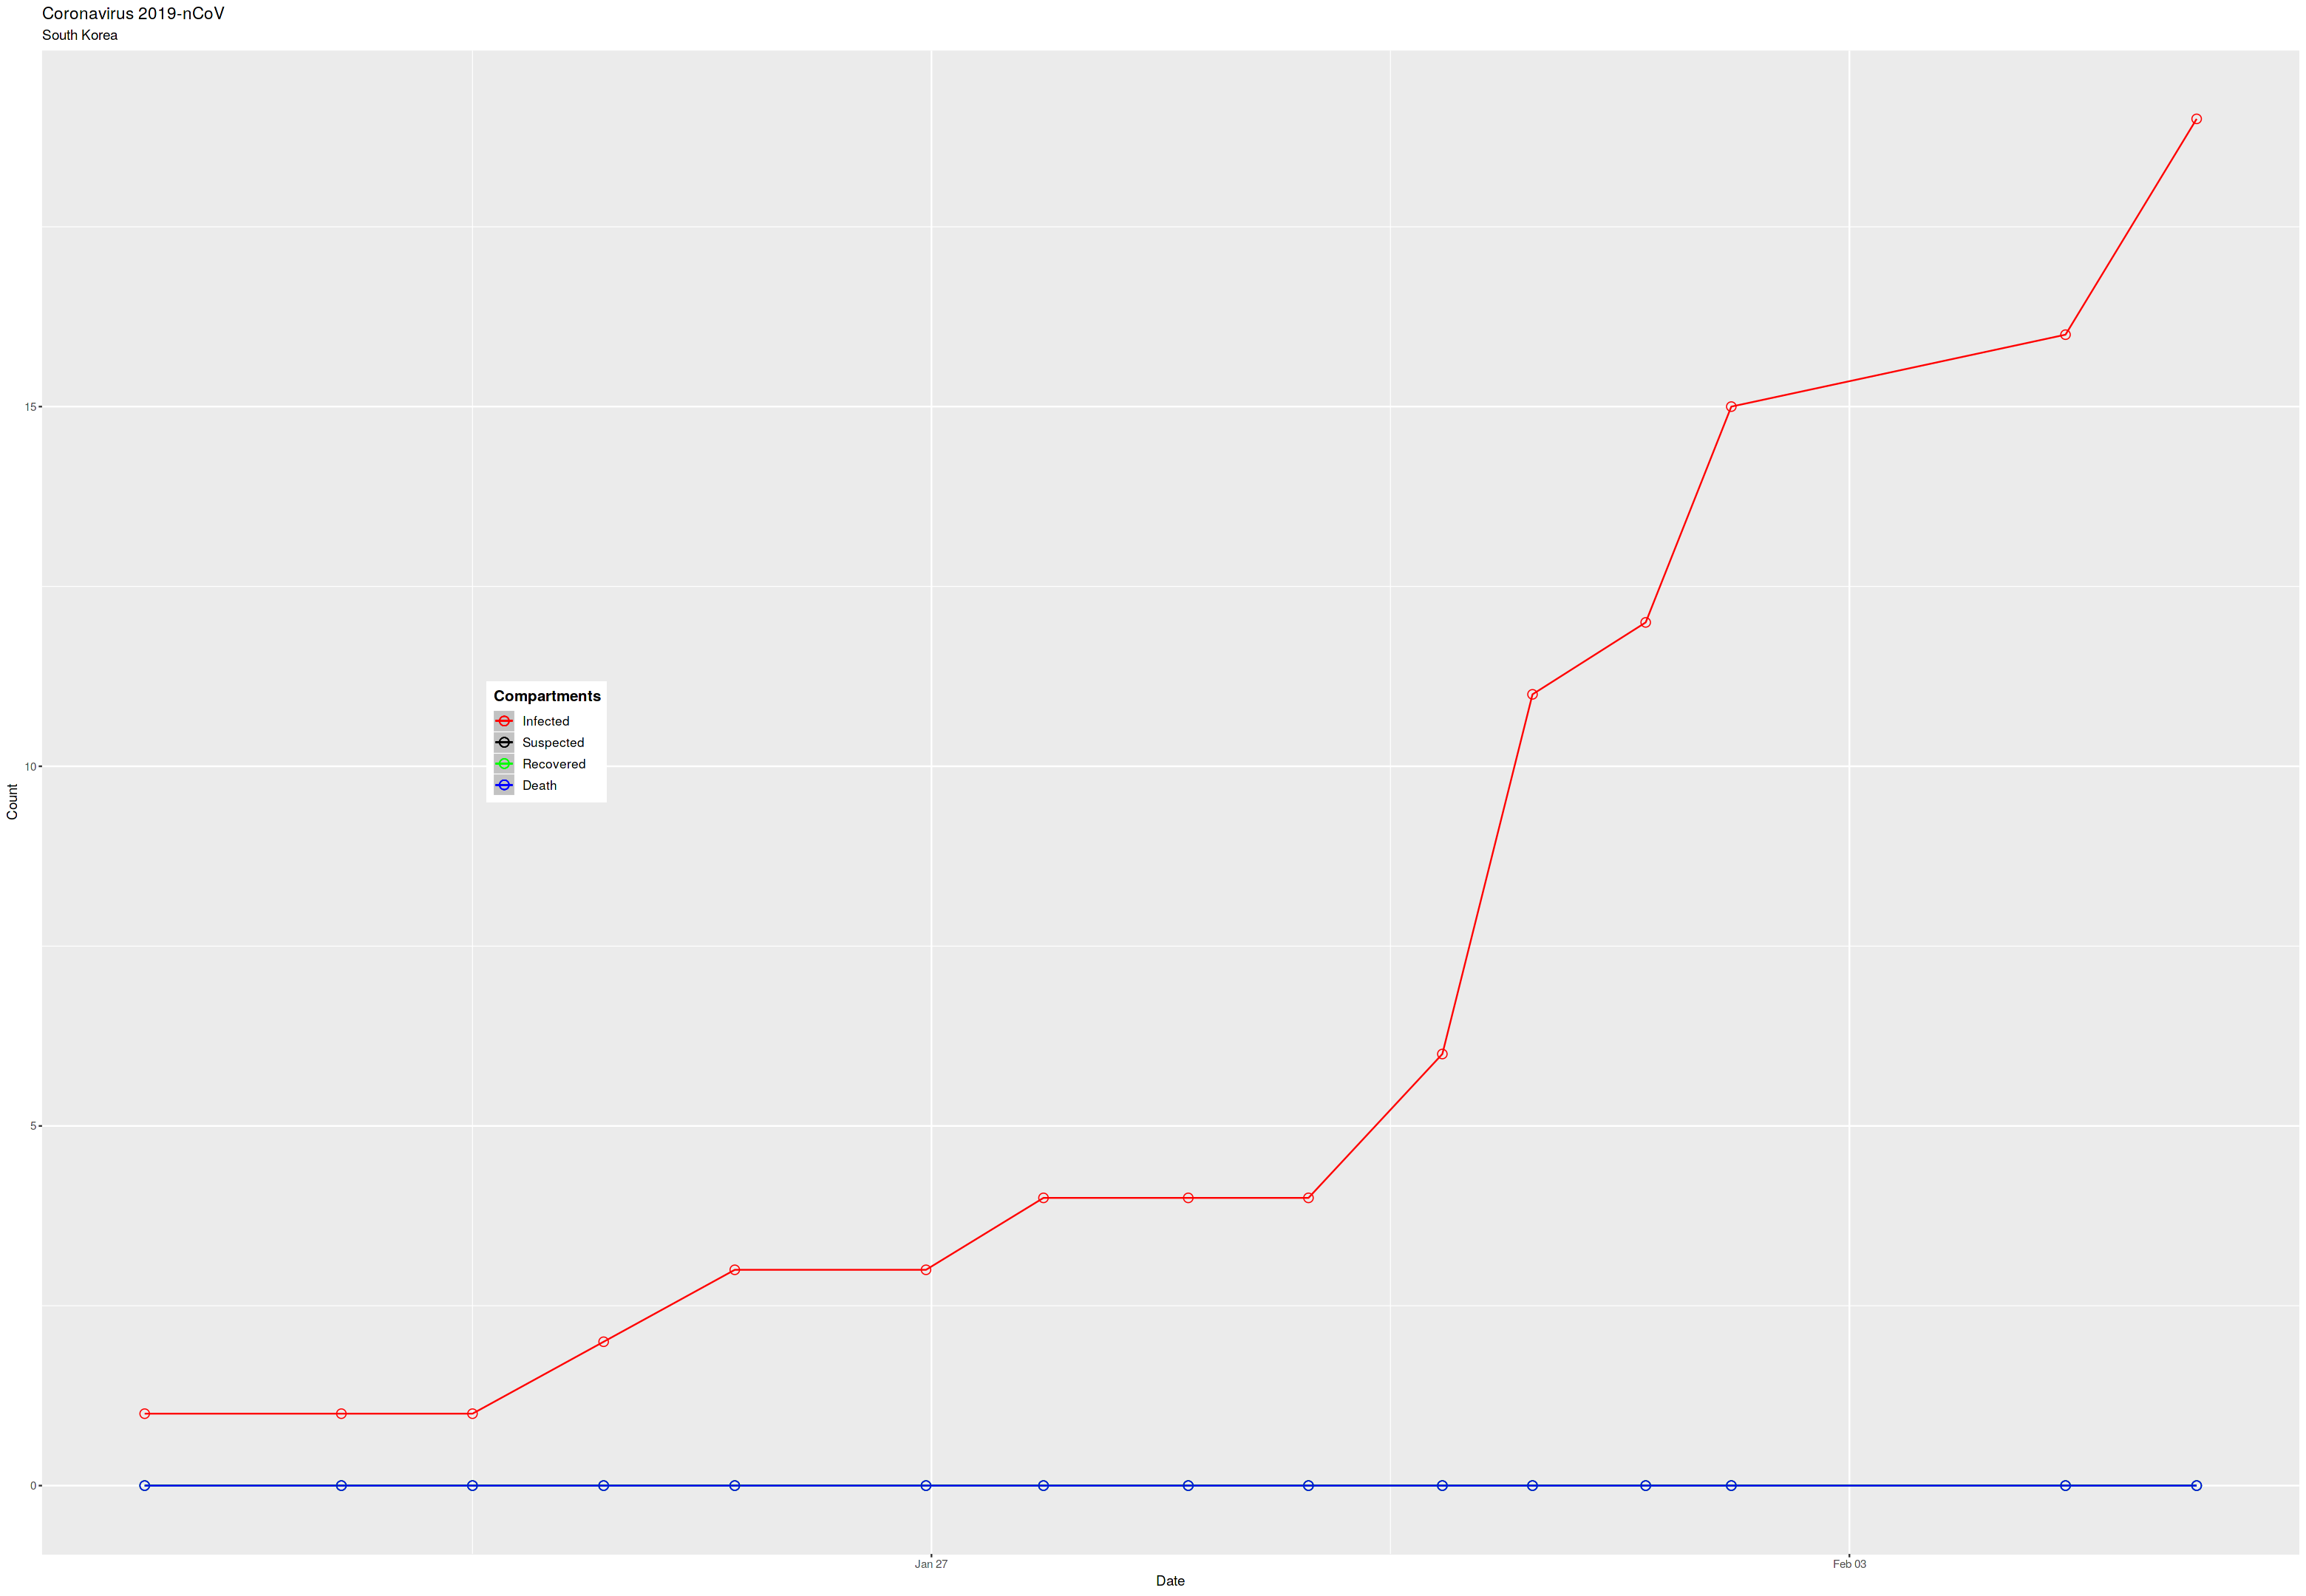

In [6]:
options(repr.plot.width = 26, repr.plot.height = 18)
dat %>% 
  filter(grepl('South Korea',`Country/Region`))  %>%
  group_by(d = day(`Last Update`)) %>% 
  filter(`Last Update` == max(`Last Update`)) %>%
  ggplot(aes(x = `Last Update`))+
      geom_line(aes(y=Confirmed, color = "Infected"))+
      geom_line(aes(y=Suspected, color = "Suspected"))+
      geom_line(aes(y=Recovered, color = "Recovered"))+
      geom_line(aes(y=Death, color = "Death"))+
  
      geom_point(size = I(3), shape = 1, aes(y=Confirmed, color = "Infected"))+
      geom_point(size = I(3), shape = 1, aes(y=Suspected, color = "Suspected"))+
      geom_point(size = I(3), shape = 1, aes(y=Recovered, color = "Recovered"))+
      geom_point(size = I(3), shape = 1, aes(y=Death, color = "Death"))+
  
      ylab(label="Count")+
      xlab(label="Date")+
      theme(legend.justification=c(1,0), legend.position=c(0.25,0.5))+
      theme(legend.title=element_text(size=12,face="bold"),
        legend.background = element_rect(fill='#FFFFFF',
                                         size=0.5,linetype="solid"),
        legend.text=element_text(size=10),
        legend.key=element_rect(colour="#FFFFFF",
                                fill='#C2C2C2',
                                size=0.25,
                                linetype="solid"))+
        scale_colour_manual("Compartments",
                      breaks=c("Infected","Suspected","Recovered","Death"),
                      values=c("blue","red","green","black"))+
        labs(title = "Coronavirus 2019-nCoV",
        subtitle = "South Korea")


A simple, back of a napkin, SEIR model.  The parameters are set based on the data from this data set.  No idea if it is correct, but interesting to see a predicted duration. Based on the actions being taken, I'm assuming it is not very accrate, but attempted to tune the differental equations parameters to match the actual Hubei province data.

In [7]:
# https://github.com/eugejoh/SIR-interact/blob/master/SIR_interactive.R

SIR.model <- function(t, b, g){
#    require(deSolve) # call in of the deSolve package
    init <- c(S=1-1e-6,I=1e-6,R=0) #initial conditions of proportion
    
    parameters <- c(bet=b,gamm=g) #paramters in the ode
    time <- seq(0,t,by=t/(2*length(1:t))) #time sequence for the ode solution
    eqn <- function(time,state,parameters){ #SIR odes
        
      with(as.list(c(state,parameters)),{ #solve the ode using the parameters
        dS <- -bet*S*I #change in proportion of susceptibles (dS/dt)
        dI <- bet*S*I-gamm*I #change in proportion of infected (dI/dt)
        dR <- gamm*I #change in proportion of the recovered (dR/dt)
        return(list(c(dS,dI,dR)))})} #out as a list containing the values
    
    out<-ode(y=init,times=time,eqn,parms=parameters) #solve the ode using ode() in deSolve package
    out.df<-as.data.frame(out) #create a data frame of the output of ode()
    
#require(ggplot2) #call in ggplot2 package
    mytheme4 <- theme_bw() + # assign a theme, all NULL values will default to bw-theme
    theme(text=element_text(colour="black")) + #set all text in the plot to white
    theme(panel.grid = element_line(colour = "white")) + #set grid in plot to white
    theme(panel.background = element_rect(fill = "#B2B2B2")) #set plot bg as grey
    theme_set(mytheme4) #http://docs.ggplot2.org/current/theme_update.html
    title <- bquote("SIR Model: Basic") #title for plot
    subtit<-bquote(list(beta==.(parameters[1]),~gamma==.(parameters[2]))) 
    #use of bquote to include Greek symbols of beta and gamma into subtitle

datAct <-
  dat %>% 
    filter(grepl('South Korea',`Country/Region`))  %>%
    group_by(`Province/State`, d = day(`Last Update`))  %>% 
    filter(`Last Update` == max(`Last Update`)) %>%
    group_by( d, m = month(`Last Update`),y=year(`Last Update`)) %>%
    summarise_if(is.numeric,sum) %>%
    mutate(Date = ymd(paste(y,m,d))) %>%
    arrange(Date) %>%
    mutate(numDays = as.numeric(c(diff(Date),1))) %>%
    as.data.table() %>%
    mutate(numDays = cumsum(numDays)) %>%
    select(Confirmed,Recovered,numDays) %>%
    as.data.table()    

datAct =  
 datAct %>%
   mutate(type = rep("Coronavirus",times = nrow(datAct)),
          Suspected = rep(0,times = nrow(datAct)),
          Expected = rep(0,times = nrow(datAct))
          ) %>% 
   as.data.table()

out.dt  =  
 out.dt %>%
   select(numDays = time, Suspected = S_pop,Confirmed = I_pop,Recovered = R_pop, Expected=E_pop) %>%
   mutate(type = rep('Model',times = nrow(out.dt))) %>%
   rbind(datAct)
   

res<-ggplot(out.df,aes(x=numDays))+ #set plot of ode data frame output and x-variable as time
    ggtitle(bquote(atop(bold(.(title)),atop(bold(.(subtit))))))+ # create the title and subtitle based on http://stackoverflow.com/q/30338719/6168956
    geom_line(aes(y=S,colour="Susceptible"))+ #assign plot line as S from out.df
    geom_line(aes(y=I,colour="Infected"))+ #assign plot line as I from out.df
    geom_line(aes(y=R,colour="Recovered"))+ #assign plot line as R from out.df
    ylab(label="Proportion")+ #y-axis label
    xlab(label="Time (days)")+ #x-axis label
    theme(legend.justification=c(1,0), legend.position=c(1,0.5))+ #legend justification - anchorpoint of legend, legend.position based on two-element numeric vector (x,y)
    theme(legend.title=element_text(size=12,face="bold"), #set font specification of title
    legend.background = element_rect(fill='#FFFFFF',size=0.5,linetype="solid"), #legend background set to white
    legend.text=element_text(size=10), #set legend text size
    legend.key=element_rect(colour="#FFFFFF", #set legend keys border to white
    fill='#C2C2C2', #fill set to gray
    size=0.25, #size of border
    linetype="solid"))+ #line type of border
    scale_colour_manual("Compartments", #title of legend
    breaks=c("Susceptible","Infected","Recovered"), #each level of lines, set to colour
    values=c("blue","red","darkgreen")) #colours for each respective level

    print(res) #print output of plot
}

In [8]:

    ggsave(plot=res, # call plot name
    filename=paste0("SIRplot_","time",t,"beta",b,"gamma",g,".png"), #set the filename with parameters of time, beta and gamma
    width=5.75,height=4,dpi=120) #dimensions and resolution of .png file
    getwd() #display working directory for saved .png file location
}

ERROR: Error in parse(text = x, srcfile = src): <text>:6:1: unexpected '}'
5:     getwd() #display working directory for saved .png file location
6: }
   ^


     time            S            I            R            E
1     0.0 9.999810e-01 0.0000190000 0.000000e+00 3.000000e-03
2     0.5 9.998725e-01 0.0003693768 7.048710e-06 2.751116e-03
3     1.0 9.995803e-01 0.0006892719 2.602704e-05 2.704428e-03
4     1.5 9.991153e-01 0.0010030371 5.624165e-05 2.825448e-03
5     2.0 9.984753e-01 0.0013300632 9.784628e-05 3.096755e-03
6     2.5 9.976486e-01 0.0016878321 1.516381e-04 3.511977e-03
7     3.0 9.966141e-01 0.0020930681 2.190024e-04 4.073803e-03
8     3.5 9.953418e-01 0.0025627258 3.019545e-04 4.793496e-03
9     4.0 9.937932e-01 0.0031148363 4.030652e-04 5.688916e-03
10    4.5 9.919188e-01 0.0037696540 5.256531e-04 6.785876e-03
11    5.0 9.896582e-01 0.0045503216 6.738101e-04 8.117644e-03
12    5.5 9.869387e-01 0.0054837128 8.524973e-04 9.725133e-03
13    6.0 9.836732e-01 0.0066012887 1.067706e-03 1.165784e-02
14    6.5 9.797582e-01 0.0079400695 1.326659e-03 1.397503e-02
15    7.0 9.750717e-01 0.0095437089 1.638016e-03 1.674659e-02
16    7.

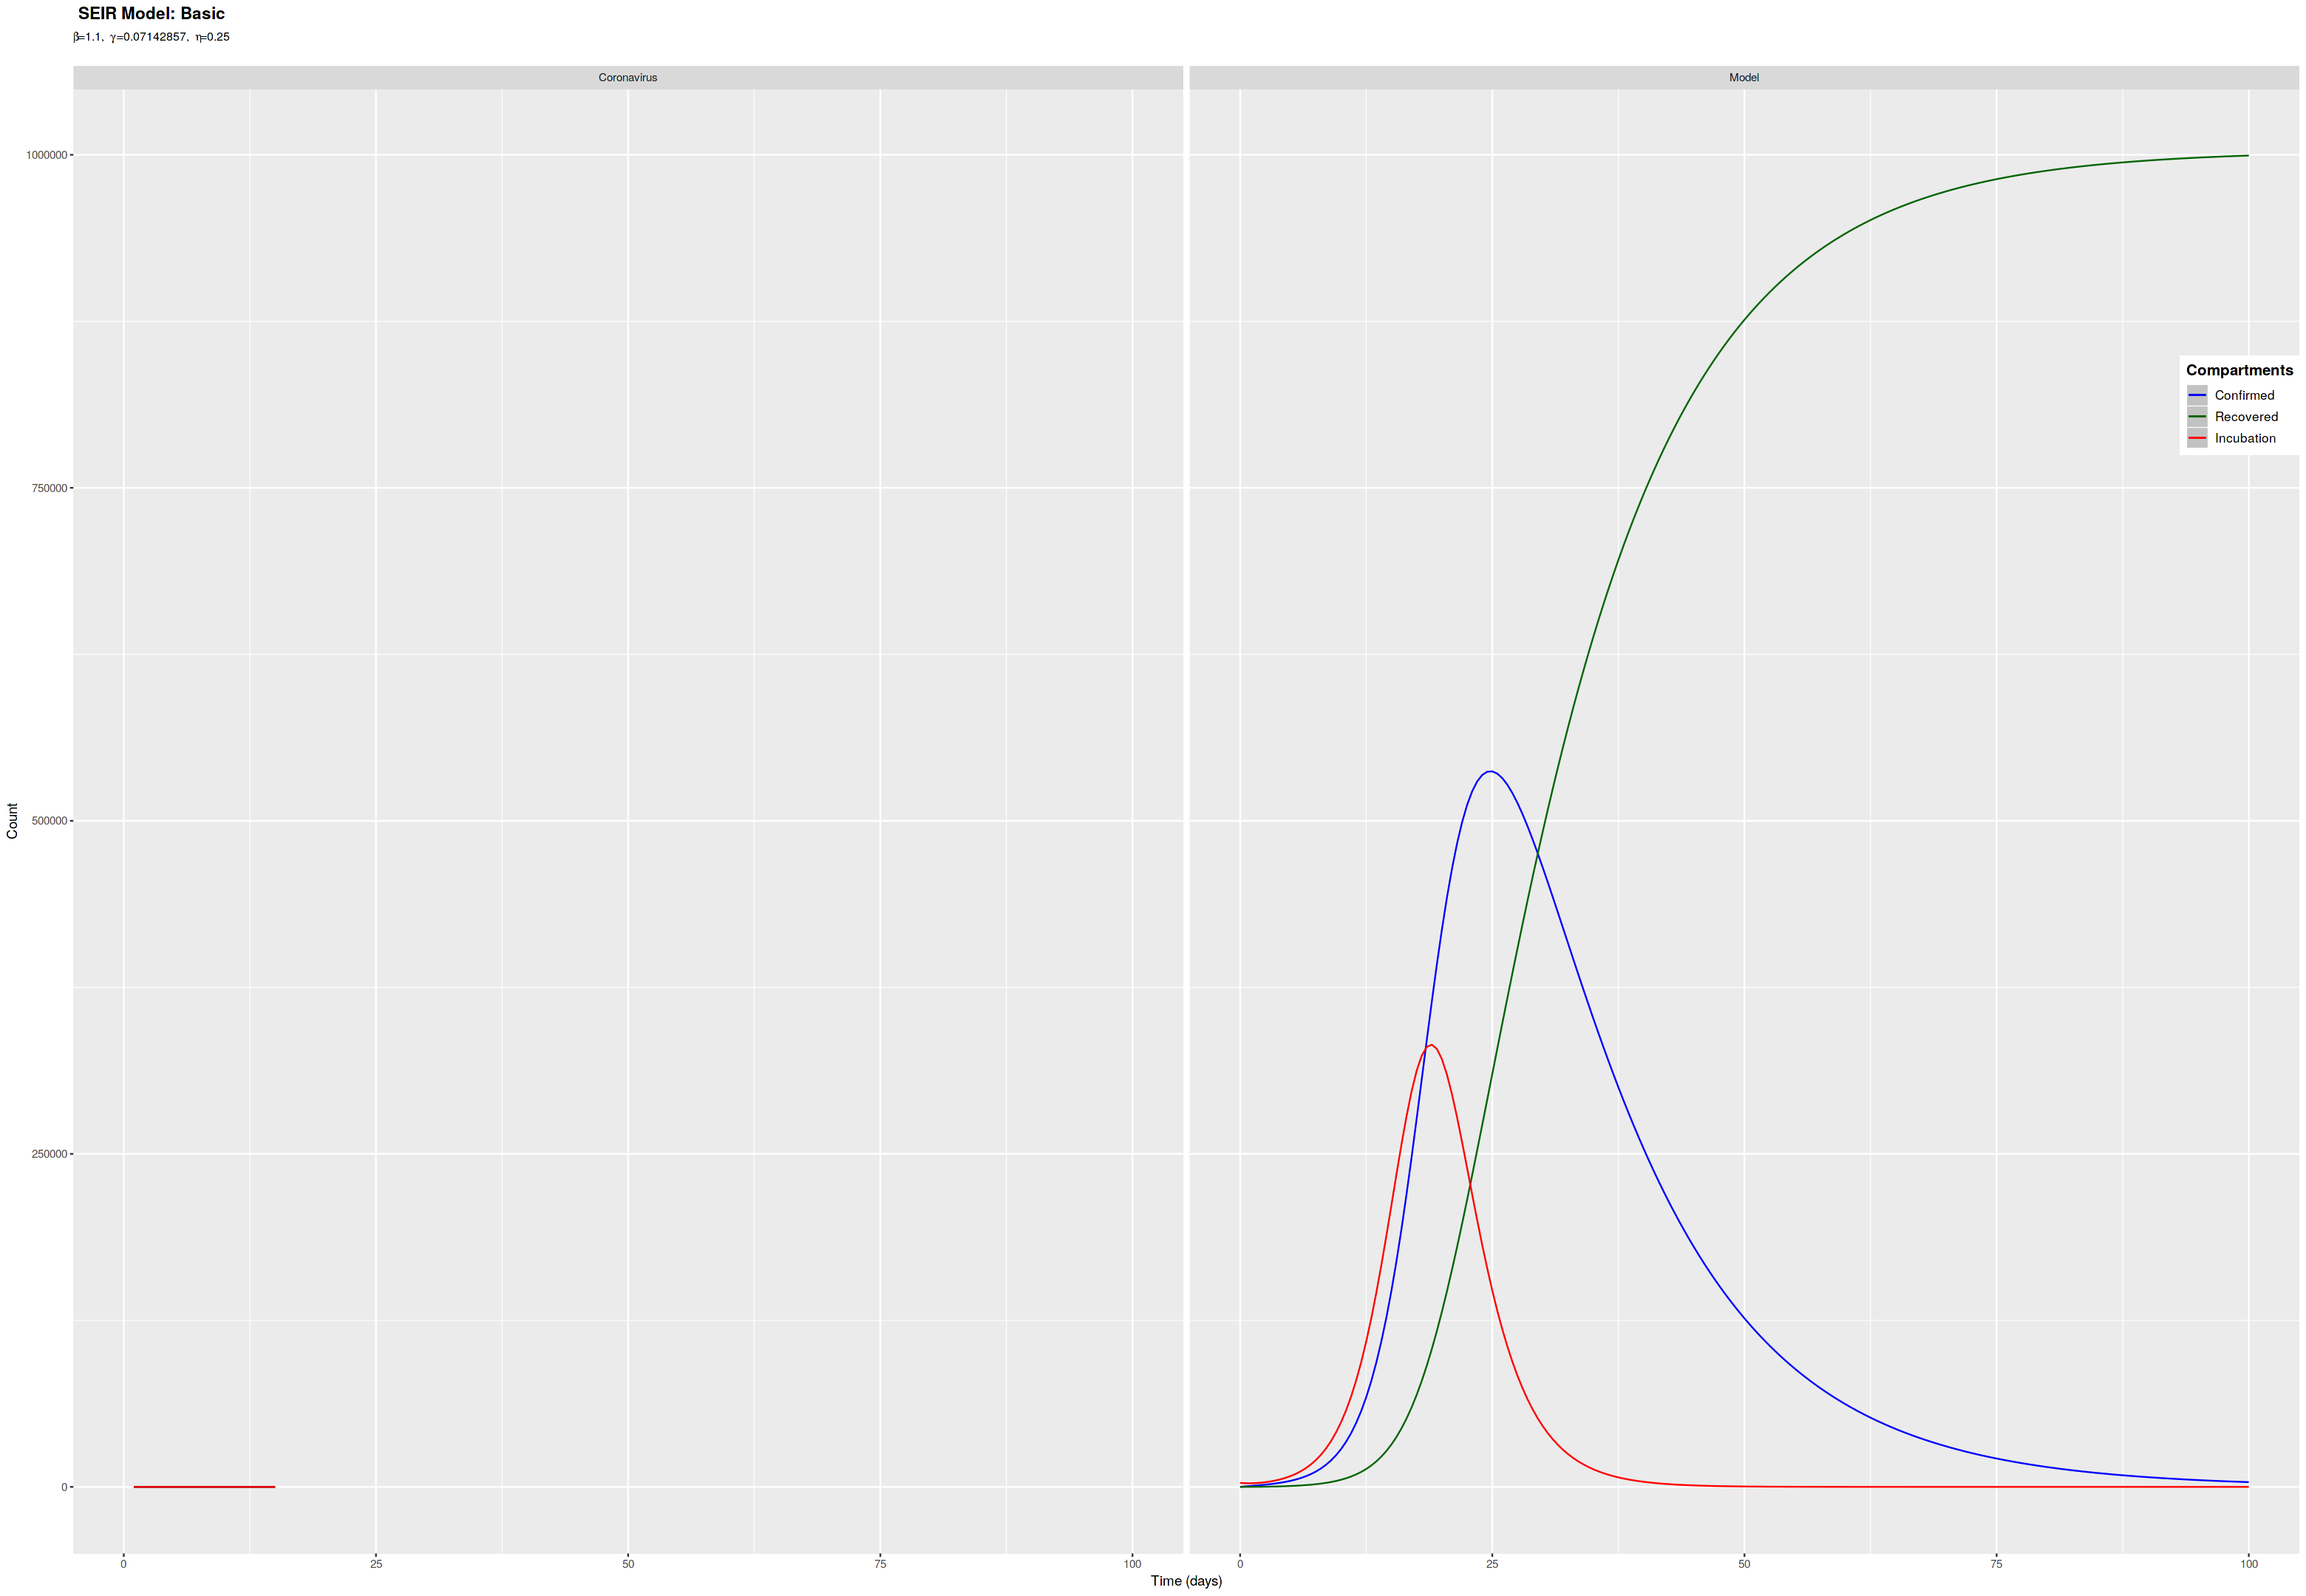

In [9]:
SEIR.model.incubation.pop <- function(t, b, g, c ,population = 1E6, infect = 19){
  
  init <- c(S=1-infect/population,I=infect/population,R=0, E=3000/population)
  parameters <- c(bet=b,gamm=g,eta=c)
  time <- seq(0,t,by=t/(2*length(1:t)))
    
    # Next we setup the differential equation (from above)
    # so that we can run the ode function from the deSolve package correctly.
  eqn <- function(time,state,parameters){
    with(as.list(c(state,parameters)),{
      dS <- -bet*S*I
      dI <- eta*E-gamm*I
      dR <- gamm*I
      dE <- bet*S*I-eta*E
      return(list(c(dS,dI,dR,dE)))})}
    # Then we run the ode function based on the parameters 
    # we set above and save coerce the output as a data frame class.
    # https://www.r-bloggers.com/sir-model-with-desolve-ggplot2/
  out<-ode(y=init,times=time,eqn,parms=parameters)
  print(out)
  out.dt<-as.data.table(out)
  
  out.dt[,S_pop := S*population]
  out.dt[,I_pop := I*population]
  out.dt[,R_pop := R*population]
  out.dt[,E_pop := E*population]
  print(parameters)
  #out.dt$S_pop <- out.dt$S*population
  #out.dt$I_pop <- out.dt$I*population
  #out.dt$R_pop <- out.dt$R*population
  #out.dt$E_pop <- out.dt$E*population
    
    options(repr.plot.width = 26, repr.plot.height = 18)
  
datAct <-
  dat %>% 
    filter(grepl('South Korea',`Country/Region`))  %>%
    group_by(d = day(`Last Update`))  %>% 
    filter(`Last Update` == max(`Last Update`)) %>%
    group_by( d, m = month(`Last Update`),y=year(`Last Update`)) %>%
    summarise_if(is.numeric,sum) %>%
    mutate(Date = ymd(paste(y,m,d))) %>%
    arrange(Date) %>%
    mutate(numDays = as.numeric(c(diff(Date),1))) %>%
    as.data.table() %>%
    mutate(numDays = cumsum(numDays)) %>%
    select(Confirmed,Recovered,numDays) %>%
    as.data.table()

datAct =  
 datAct %>%
   mutate(type = rep("Coronavirus",times = nrow(datAct)),
          Suspected = rep(0,times = nrow(datAct)),
          Expected = rep(0,times = nrow(datAct))
          ) %>% 
   as.data.table()

out.dt  =  
 out.dt %>%
   select(numDays = time, Suspected = S_pop,Confirmed = I_pop,Recovered = R_pop, Expected=E_pop) %>%
   mutate(type = rep('Model',times = nrow(out.dt))) %>%
   rbind(datAct)
   
   title <- bquote("SEIR Model: Basic")
   subtit <- bquote(list(beta==.(parameters[1]),~gamma==.(parameters[2]),~eta==.(parameters[3])))
   
   res<-ggplot(out.dt,aes(x=numDays))+
     ggtitle(bquote(atop(bold(.(title)),atop(bold(.(subtit))))))+
     #geom_line(aes(y=S_pop,colour="Susceptible"))+
     geom_line(aes(y=Confirmed,colour="Confirmed"))+
     geom_line(aes(y=Recovered,colour="Recovered"))+
     geom_line(aes(y=Expected,colour="Incubation"))+
     ylab(label="Count")+
     xlab(label="Time (days)")+
     facet_grid(.~type)+
     theme(legend.justification=c(1,0), legend.position=c(1,0.75))+
     theme(legend.title=element_text(size=12,face="bold"),
           legend.background = element_rect(fill='#FFFFFF',
                                            size=0.5,linetype="solid"),
           legend.text=element_text(size=10),
           legend.key=element_rect(colour="#FFFFFF",
                                   fill='#C2C2C2',
                                   size=0.25,
                                   linetype="solid"))+
     scale_colour_manual("Compartments",
                         breaks=c("Susceptible","Confirmed","Recovered","Incubation"),
                         values=c("blue","red","darkgreen","black"))
   
   res
}

#                function(t, b, g, c
SEIR.model.incubation.pop(100,1.1,1/14,1/4)


Function to compute derivatives of the differential equations.

# SEIR Model
https://rpubs.com/srijana/110753

In [10]:
#library (deSolve) 
seir_model = function (current_timepoint, state_values, parameters)
{
  # create state variables (local variables)
  S = state_values [1]        # susceptibles
  E = state_values [2]        # exposed
  I = state_values [3]        # infectious
  R = state_values [4]        # recovered
  
  with ( 
    as.list (parameters),     # variable names within parameters can be used 
         {
           # compute derivatives
           dS = (-beta * S * I)
           dE = (beta * S * I) - (delta * E)
           dI = (delta * E) - (gamma * I)
           dR = (gamma * I)
           
           # combine results
           results = c (dS, dE, dI, dR)
           list (results)
         }
    )
}

Parameters
Compute values of beta (tranmission rate) and gamma (recovery rate).

# 파라미터의 최적값이 아님. 파라미터를 최적화시켜서 대입해야 코드가 완성됨.

In [11]:
contact_rate = 5            #중국논문 참고 Ro = k * b * Recovery Time = 2.7    beta = k*b =0.1934
                            # number of contacts per day =5
transmission_probability = 0.07       # transmission probability
infectious_period = 14                 # infectious period
latent_period = 4                     # latent period

beta_value = 0.1934 # contact_rate * transmission_probability = 0.35
gamma_value = 1 / infectious_period
delta_value = 1 / latent_period
beta_value

[1] 0.1934

Compute Ro - Reproductive number.

In [12]:
Ro = beta_value / gamma_value
Ro

[1] 2.7076

Disease dynamics parameters.

In [13]:
parameter_list = c (beta = beta_value, gamma = gamma_value, delta = delta_value)

Initial values for sub-populations.

In [14]:
W = 9772        # susceptible hosts
X = 31           # infectious hosts
Y = 2           # recovered hosts
Z = 818           # exposed hosts

Compute total population.

In [15]:
N = W + X + Y + Z

Initial state values for the differential equations.

In [16]:
initial_values = c (S = W/N, E = X/N, I = Y/N, R = Z/N)

Output timepoints.

In [17]:
timepoints = seq (0, 100, by=1)

Simulate the SEIR epidemic.

In [18]:
output = lsoda (initial_values, timepoints, seir_model, parameter_list)

Plot dynamics of Susceptibles, Exposed, Infectious and Recovered sub-populations in the same plot.

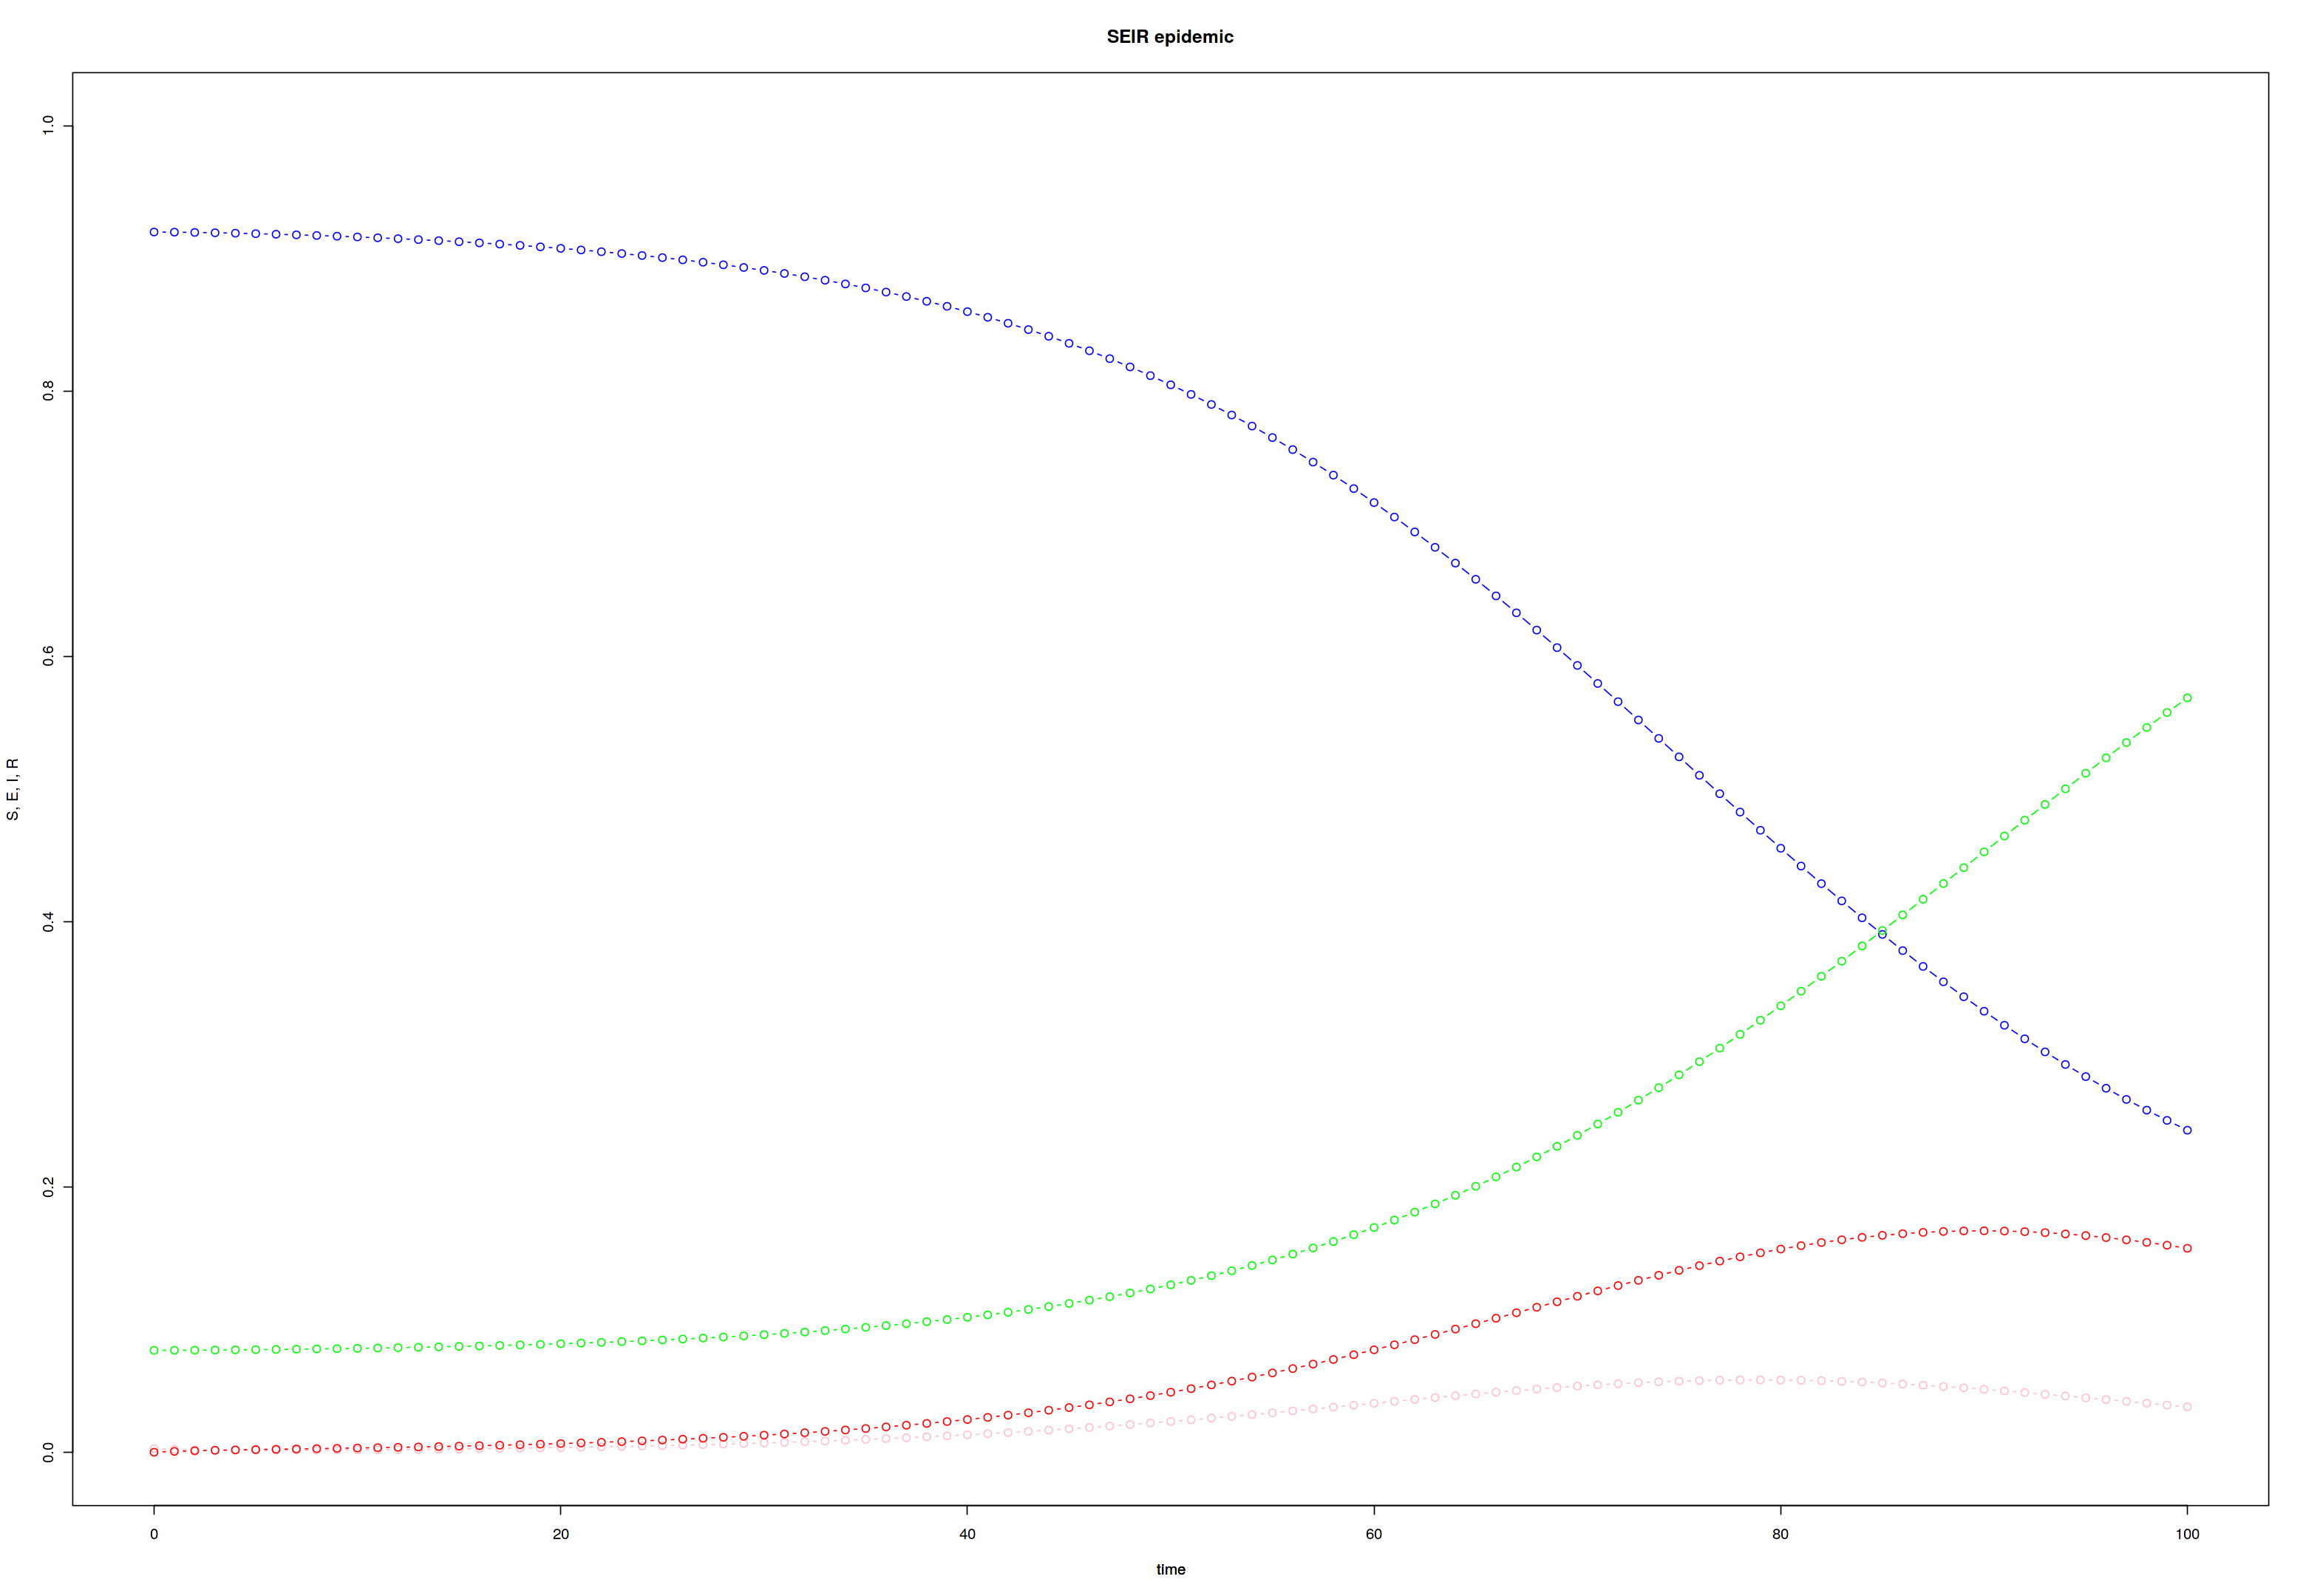

In [19]:
# susceptible hosts over time
plot (S ~ time, data = output, type='b', ylim = c(0,1), col = 'blue', ylab = 'S, E, I, R', main = 'SEIR epidemic') 

# remain on same frame
par (new = TRUE)    

# exposed hosts over time
plot (E ~ time, data = output, type='b', ylim = c(0,1), col = 'pink', ylab = '', axes = FALSE)

# remain on same frame
par (new = TRUE) 

# infectious hosts over time
plot (I ~ time, data = output, type='b', ylim = c(0,1), col = 'red', ylab = '', axes = FALSE) 

# remain on same frame
par (new = TRUE)  

# recovered hosts over time
plot (R ~ time, data = output, type='b', ylim = c(0,1), col = 'green', ylab = '', axes = FALSE)

Plot dynamics of Susceptibles sub-population

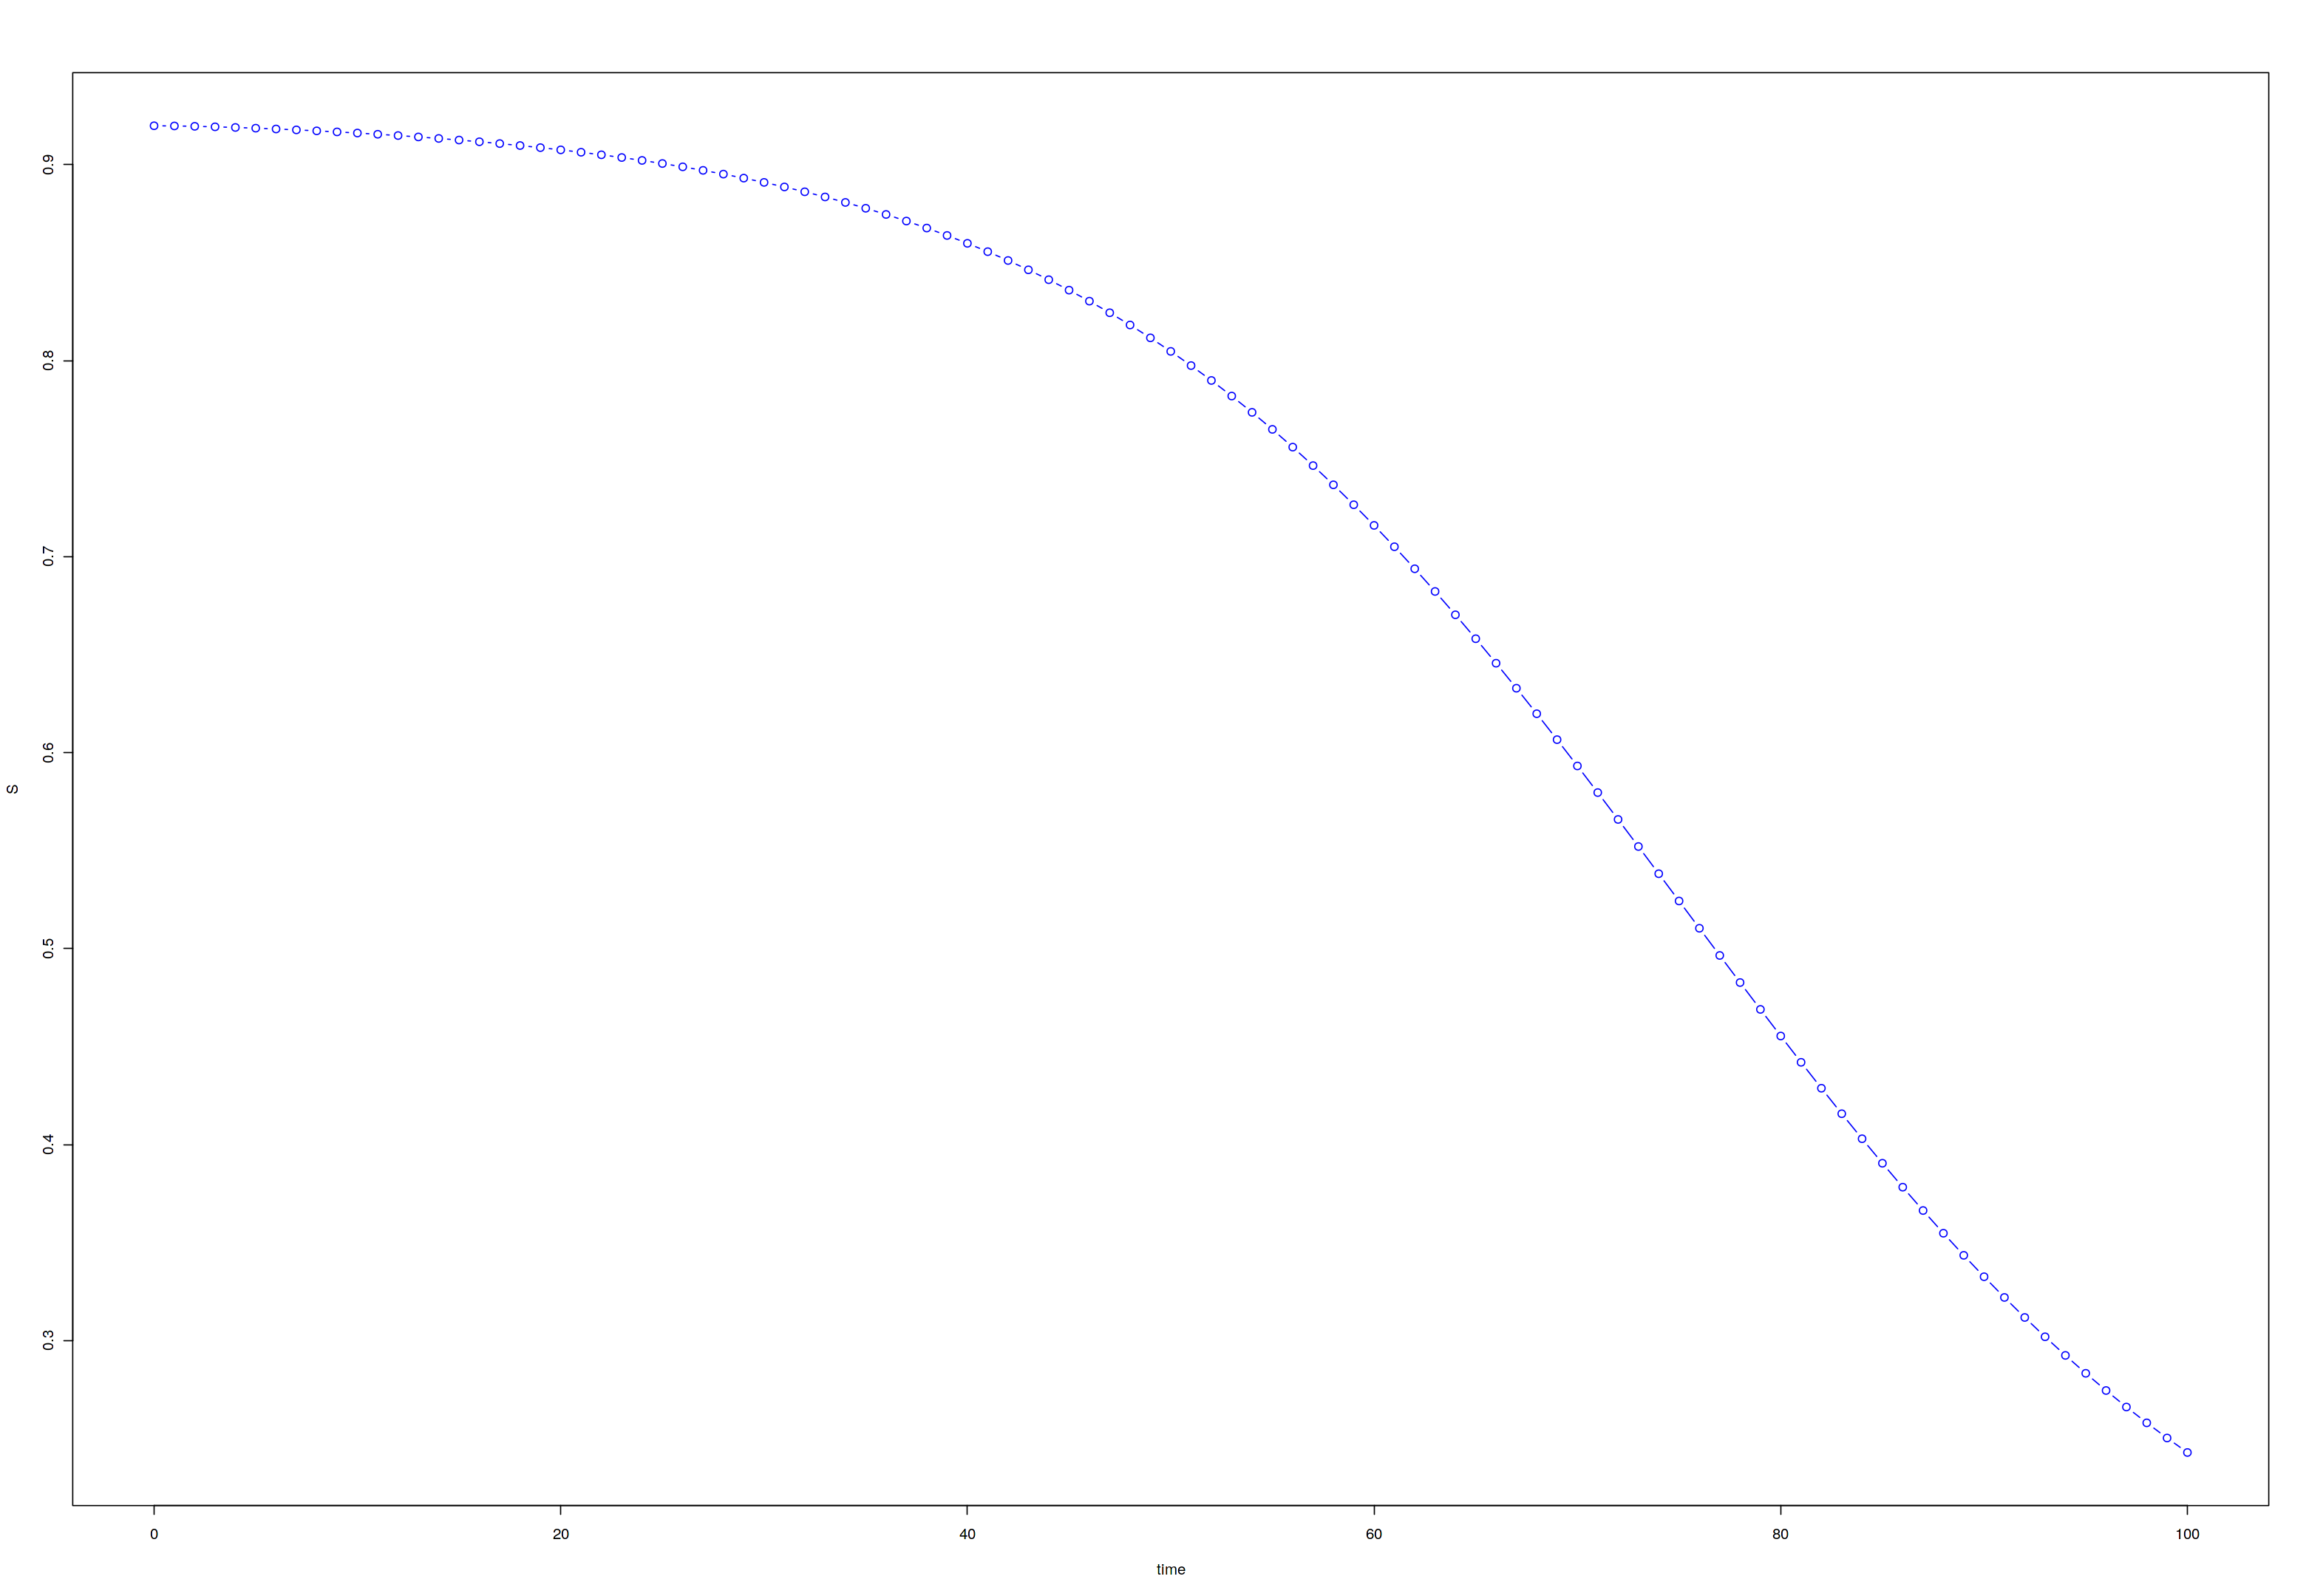

In [20]:
plot (S ~ time, data = output, type='b', col = 'blue')   

population

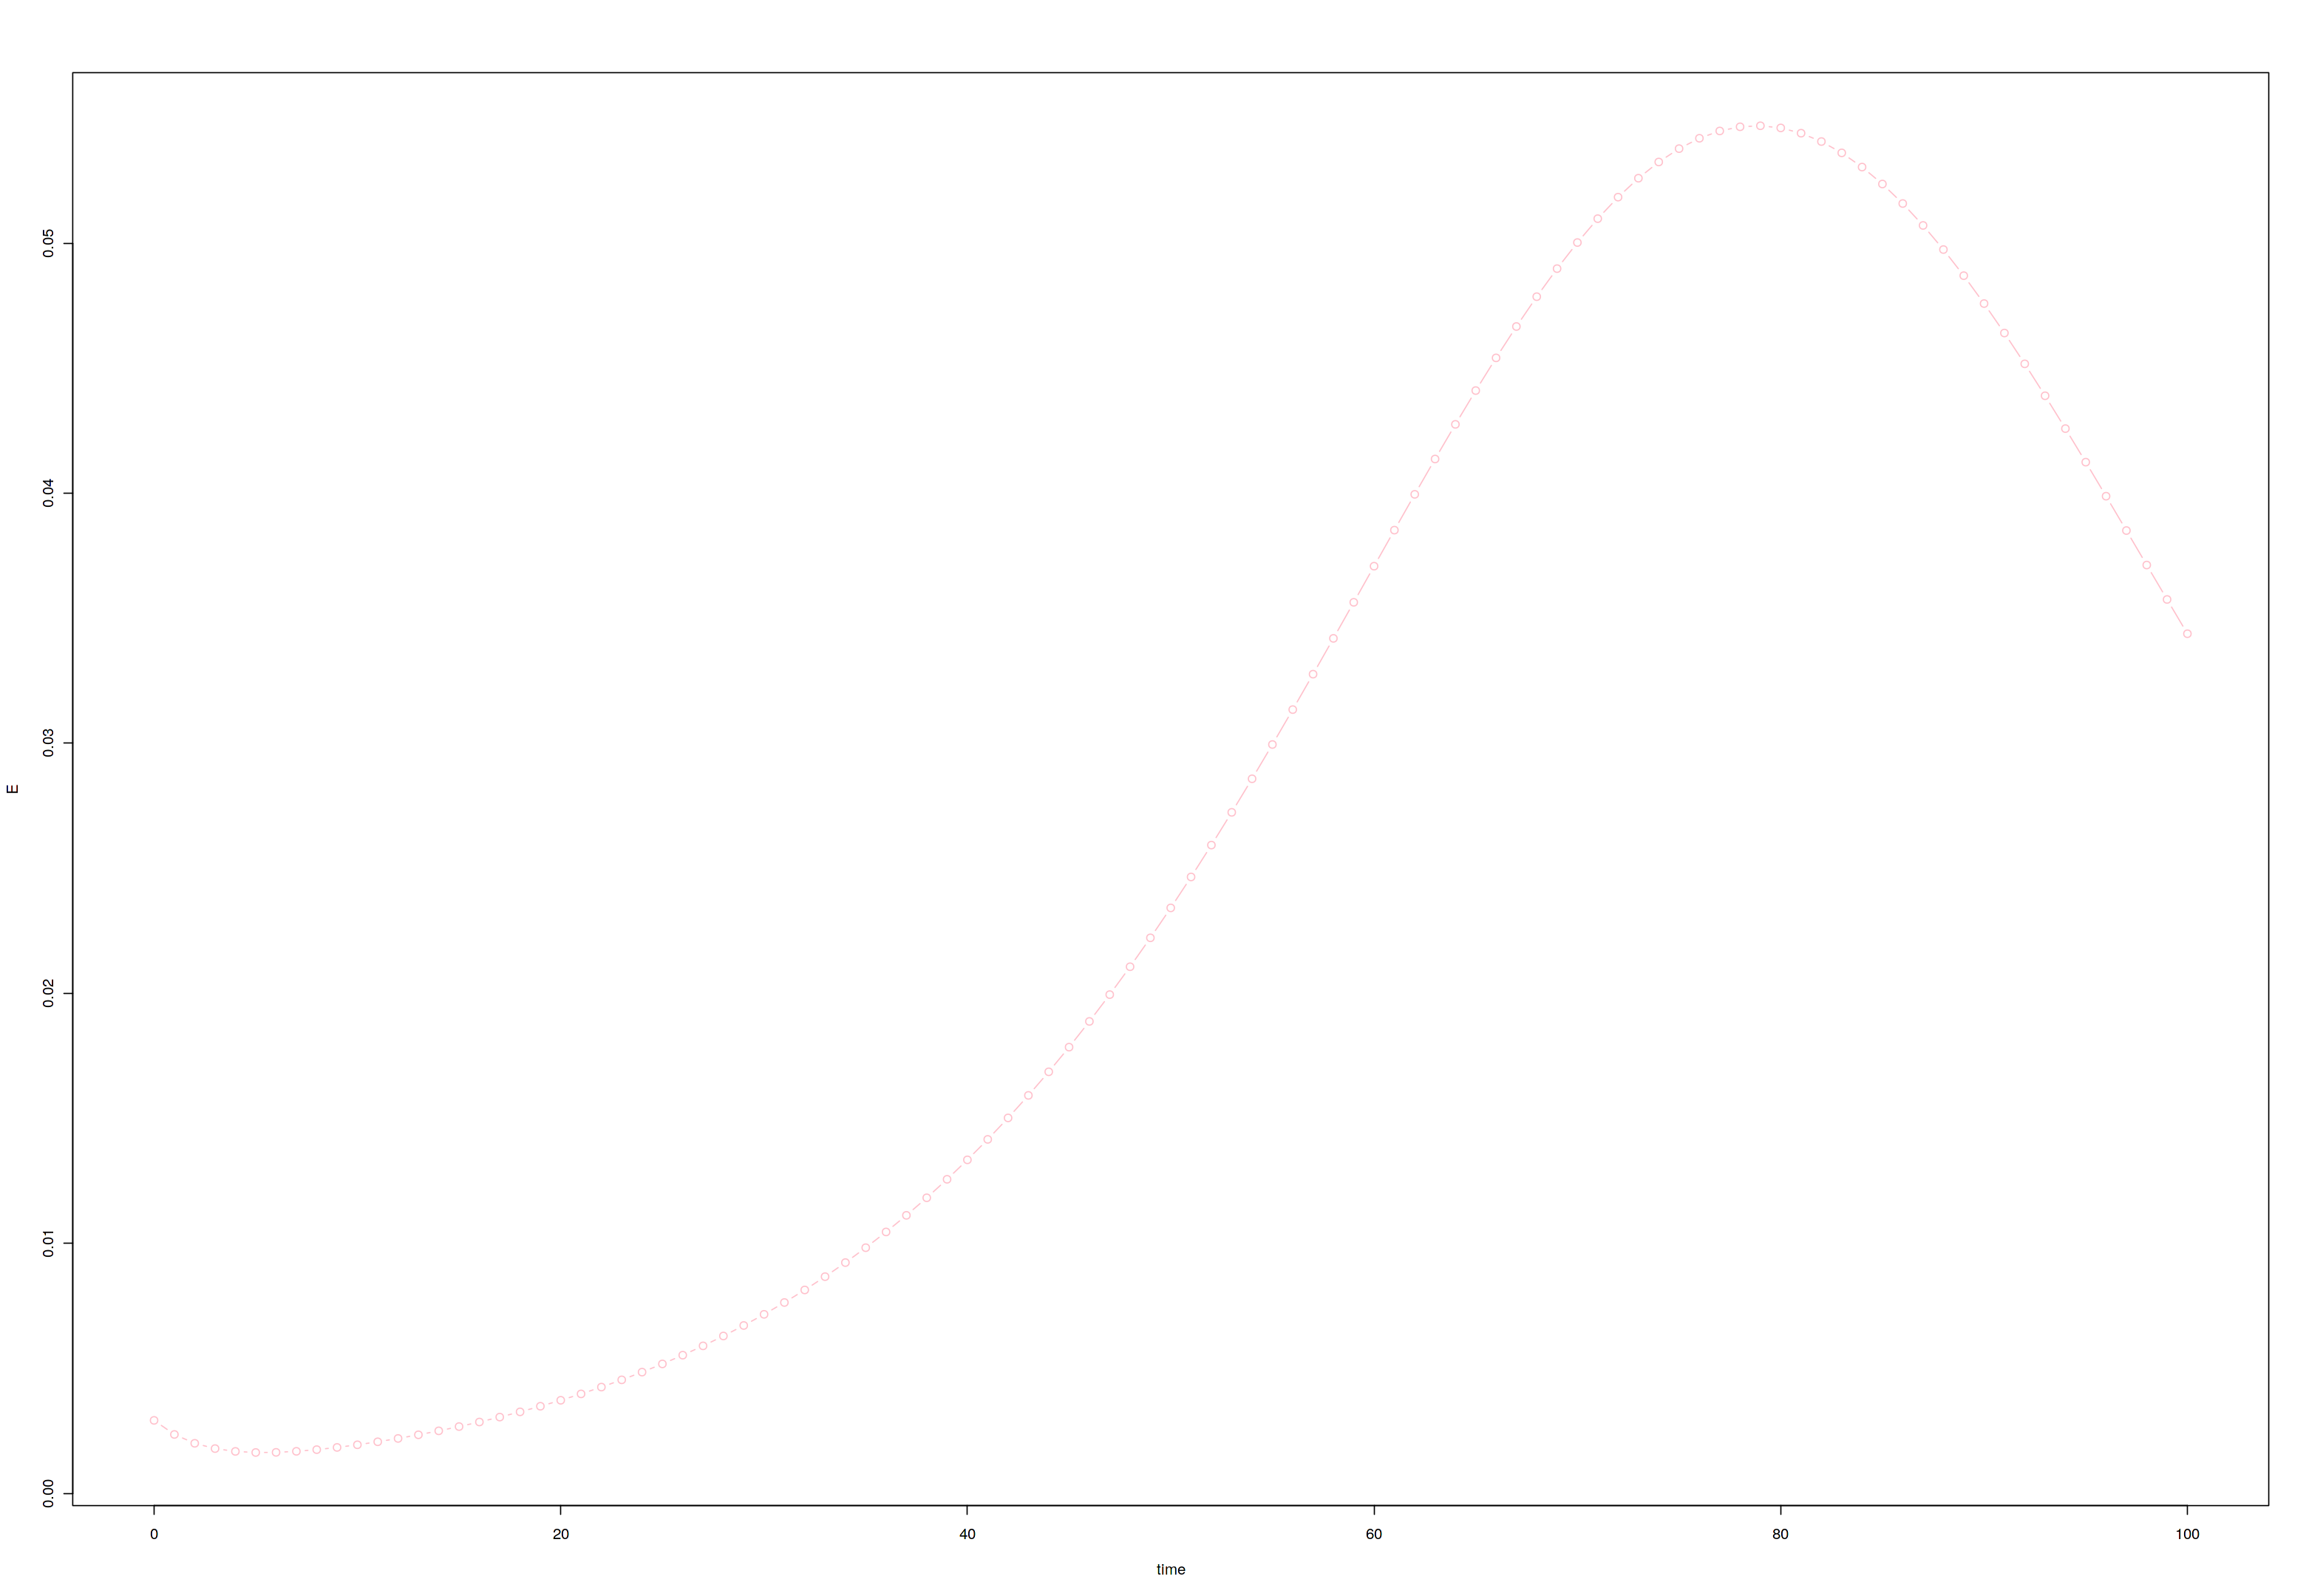

In [21]:
plot (E ~ time, data = output, type='b', col = 'pink')  

Plot dynamics of Infectious sub-population.

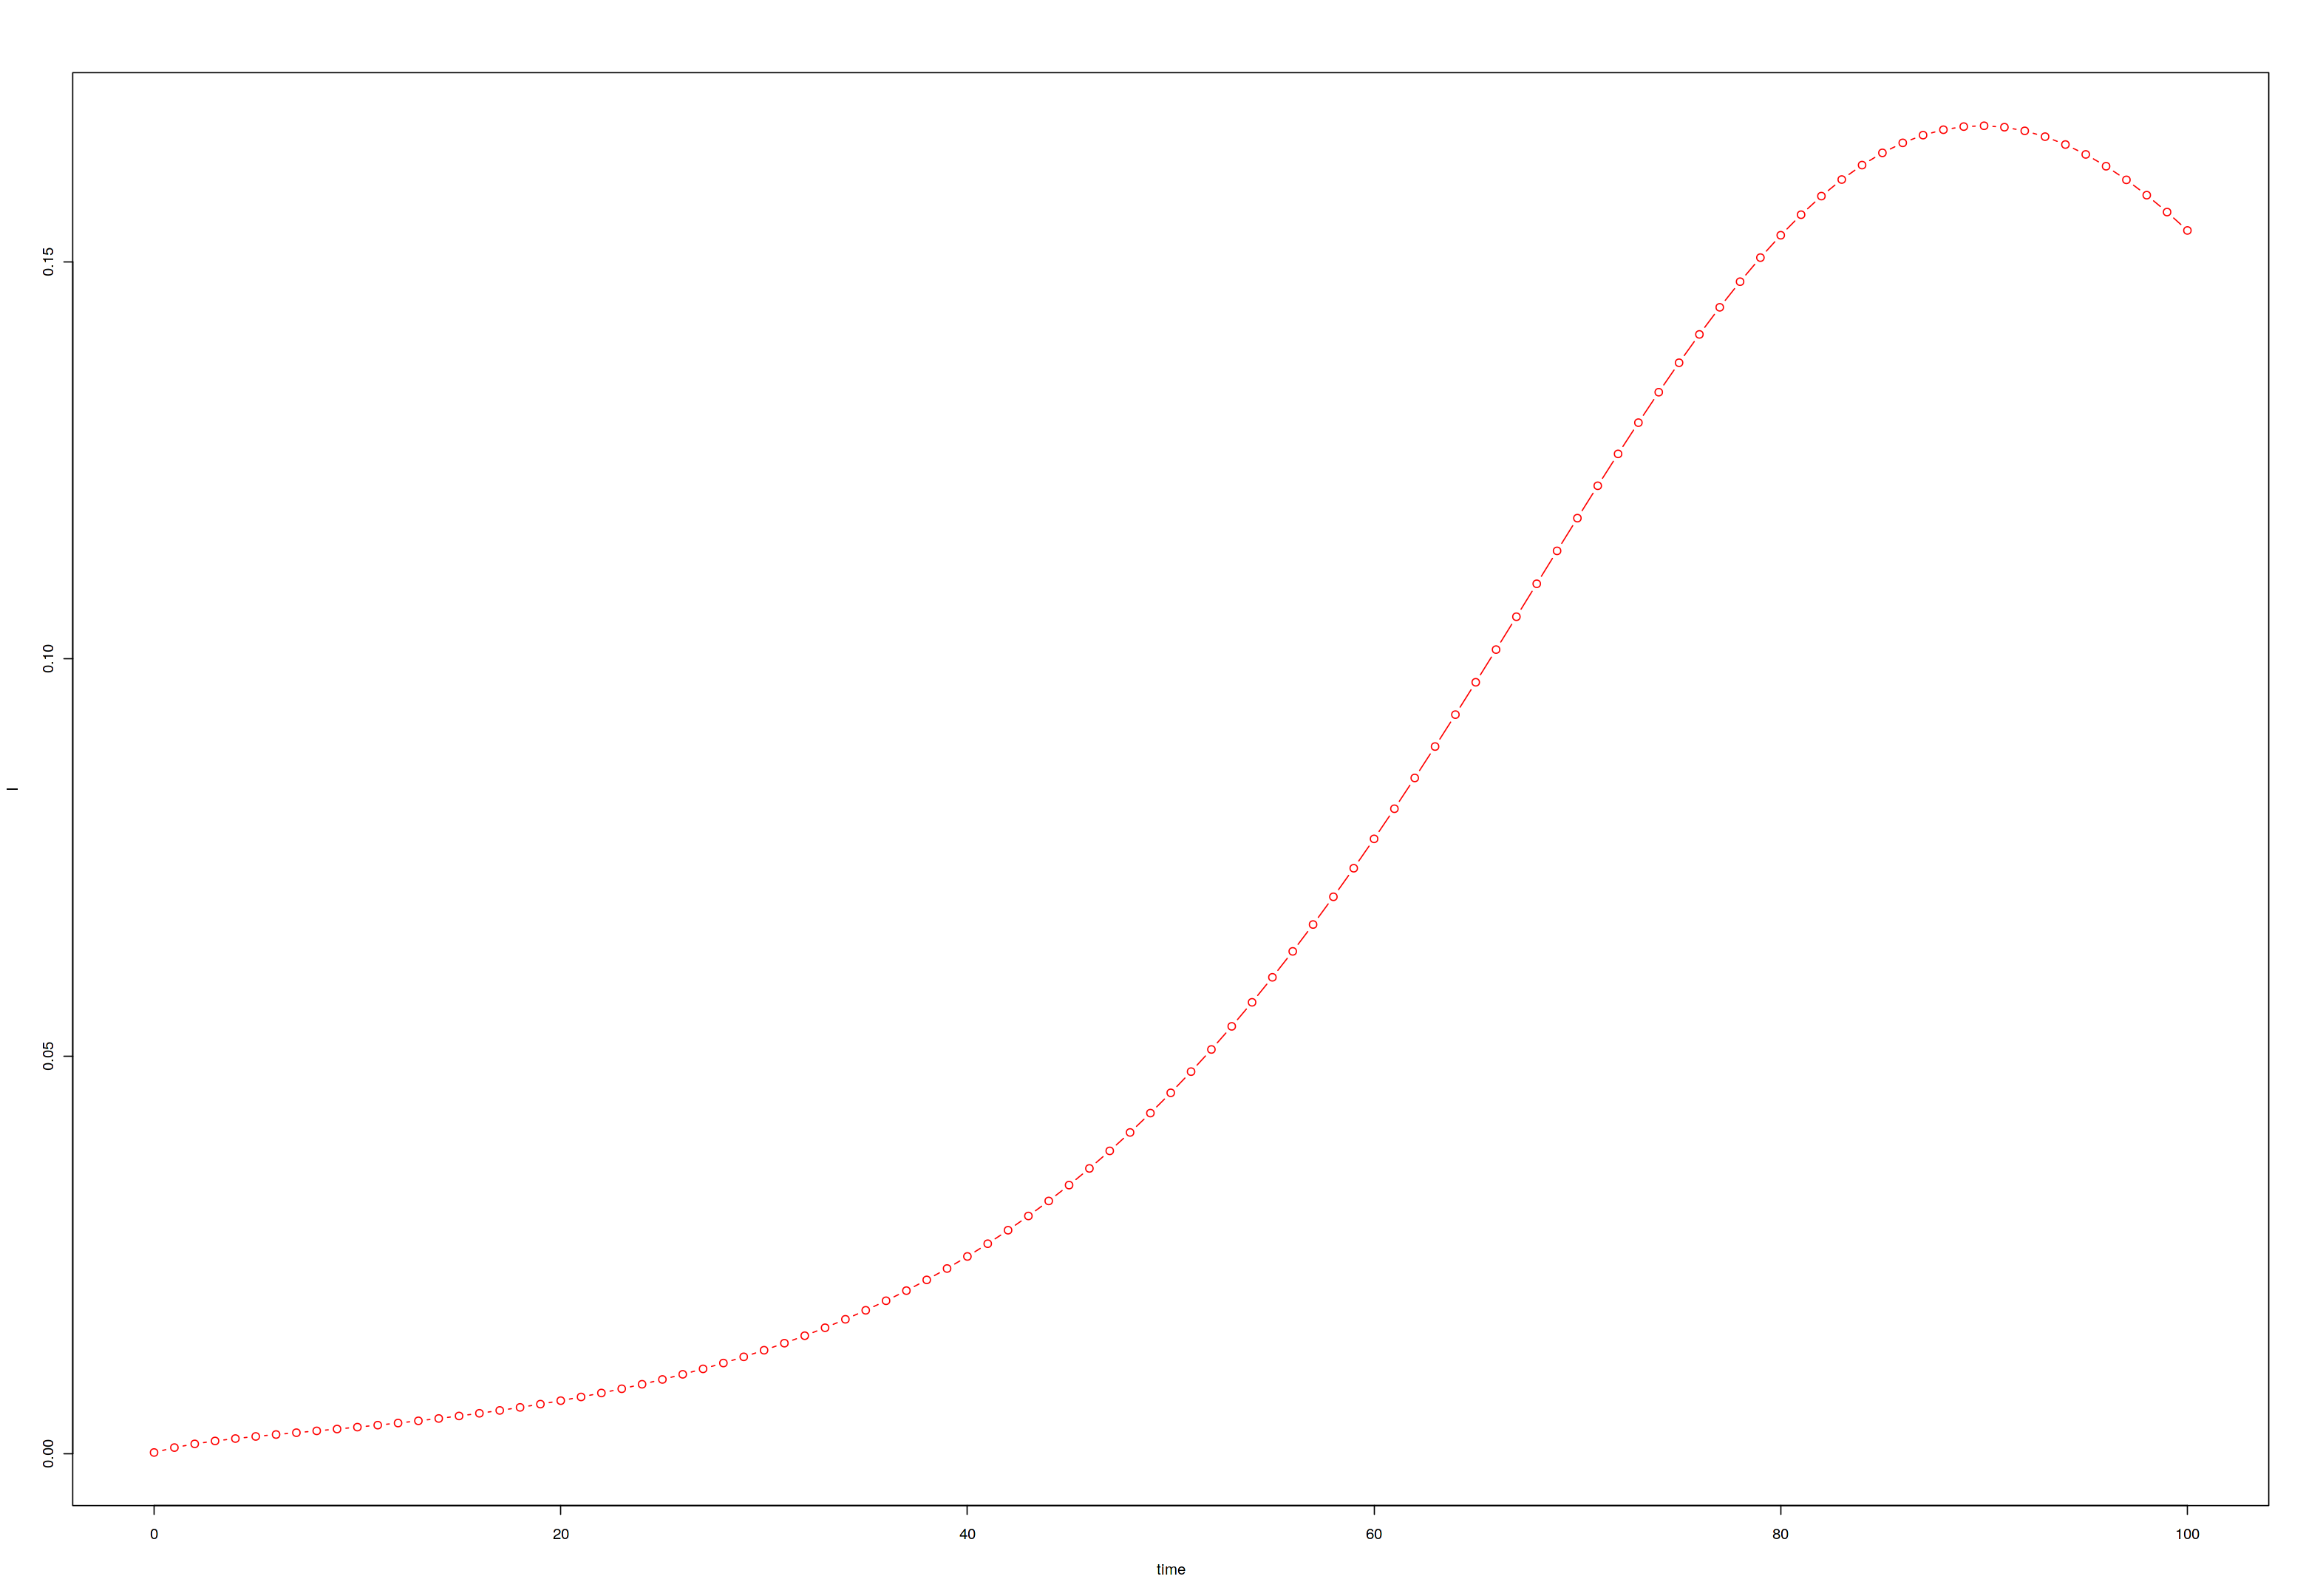

In [22]:
plot (I ~ time, data = output, type='b', col = 'red') 

Plot dynamics of Recovered sub-population.

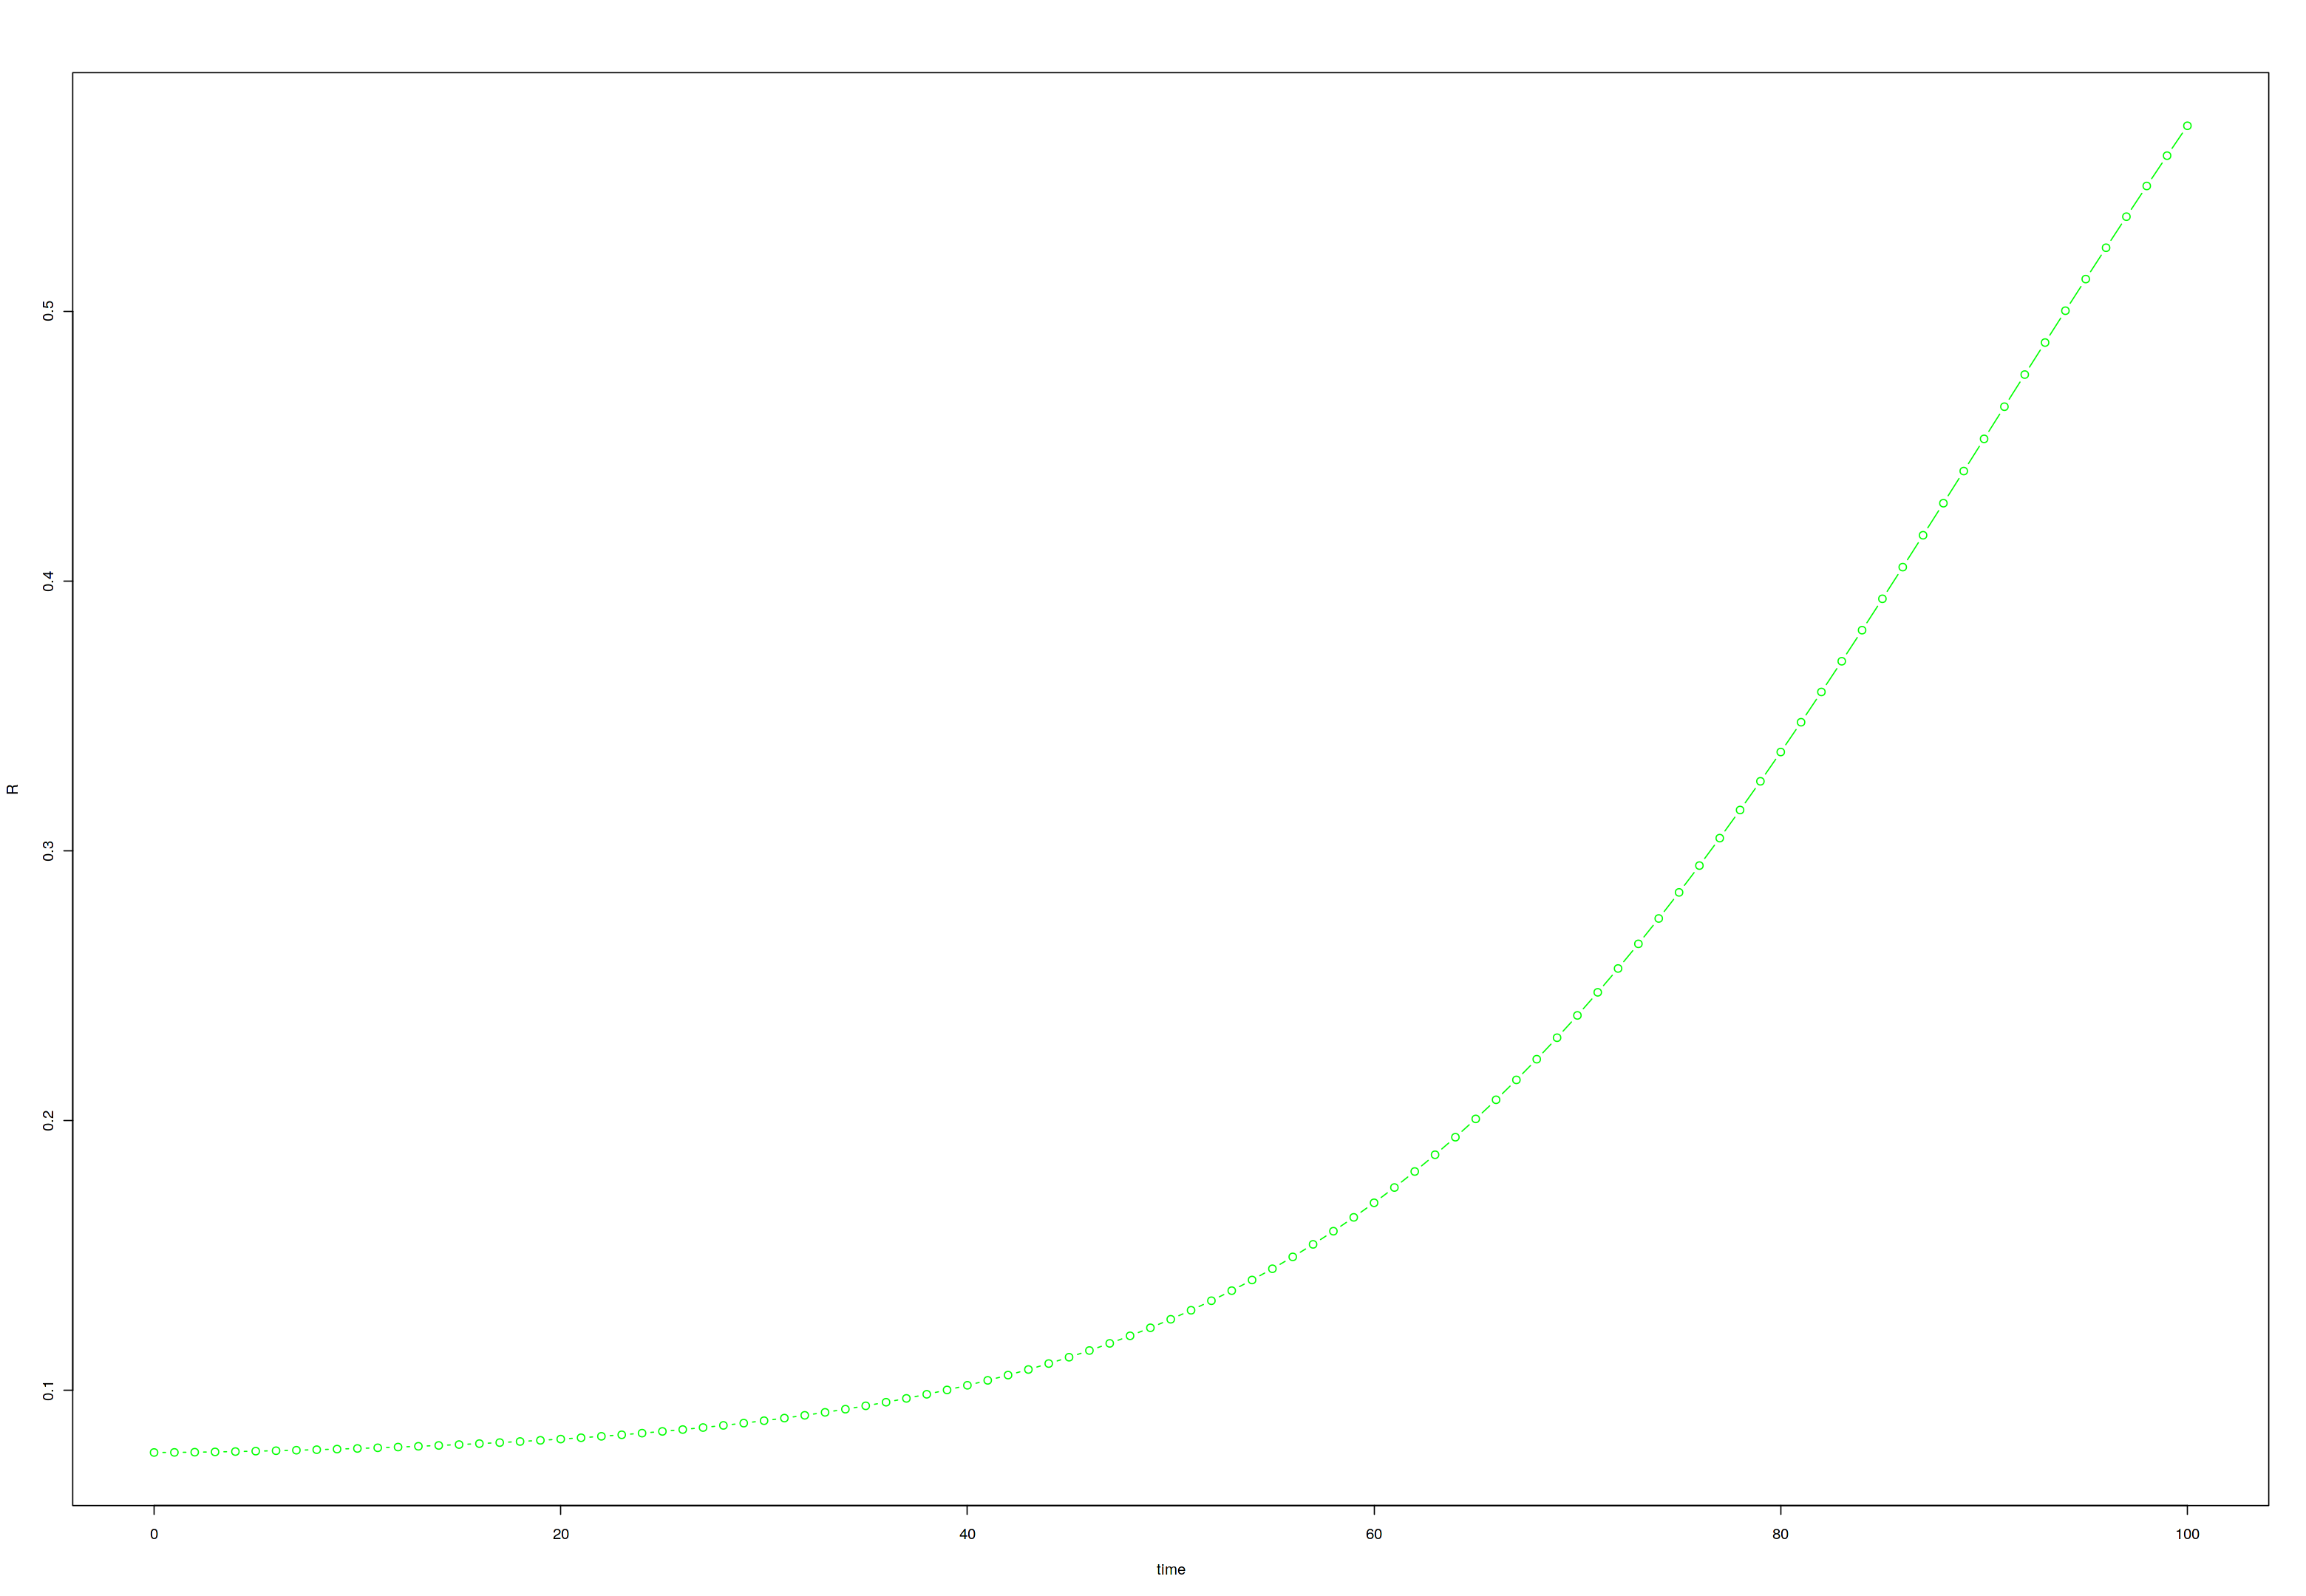

In [23]:
plot (R ~ time, data = output, type='b', col = 'green')  